# Calculate overlap reduction functions 
## Overlap reduction function calculation for arbitrary baselines

In this tutorial we will demonstrate how to calculate the overlap reduction function (ORF) for arbitrary baselines, which encodes the geometric sensitivity of a given detector pair as a function of the relative positions and orientations of the two interferometers. 

First we import the necessary modules. We will use the `Baseline` module of `pygwb`. For more information on the `Baseline` module, we refer the user to the [documentation page](api/pygwb.baseline.html).

In [8]:
import numpy as np
import matplotlib.pyplot as plt 
import bilby
from copy import deepcopy
from pygwb.baseline import Baseline
import seaborn as sns
my_palette = sns.color_palette("colorblind")

Next we initialize empty `Interferometer` objects for LIGO Livingston, LIGO India, Virgo, Kagra, and Einstein Telescope. The latter is a `TringularInterferometer` object, which consists of three separate `Interferometer` objects at the vertices of an equilateral triangle. The `Interferometer` objects store the location information for each detector, like the latitude and longitude of the vertex and angle of the arms.

In [2]:
L1 = bilby.gw.detector.get_empty_interferometer('L1')
A1 = bilby.gw.detector.get_empty_interferometer('A1')
V1 = bilby.gw.detector.get_empty_interferometer('V1')
K1 = bilby.gw.detector.get_empty_interferometer('K1')
ET = bilby.gw.detector.get_empty_interferometer('ET')

More information about the `Interferometer` object can be found [here](api/pygwb.detector.Interferometer.html). For additional information on the `bilby.gw.detector` object, we refer the user to the [documentation](https://lscsoft.docs.ligo.org/bilby/api/bilby.gw.detector.html).

Next, we set the frequencies in each interferometer. We use a maximum frequency of 2048 Hz sampled with a spacing of $\delta f = 1/T = 0.25~\mathrm{Hz}$, where $T$ is the analysis segment duration:

In [3]:
duration = 4 
freqs = np.arange(0,2048,1./duration)
masks = []
for ifo in [L1, A1, V1, K1, ET]:
    if ifo.name=='ET':
        for i in range(3):
            ifo[i].strain_data.frequency_array = freqs
    else:
        ifo.strain_data.frequency_array = freqs

Now let's define some baselines with the interferometers initialized above. This constitutes a pair of detectors. We define a few different baselines with the ET interferometers to demonstrate the ORF normalization for detectors with non-90-degree arms.

In [4]:
L1V1 = Baseline('L-V', L1, V1, frequencies=freqs, duration=duration)
L1A1 = Baseline('L-A', A1, L1, frequencies=freqs, duration=duration)
V1K1 = Baseline('V-K', V1, K1, frequencies=freqs, duration=duration)
A1ET = Baseline('A-ET', A1, ET[0], frequencies=freqs, duration=duration)
ET01 = Baseline('ET 01', ET[0], ET[1], frequencies=freqs, duration=duration)
ET02 = Baseline('ET 02', ET[0], ET[2], frequencies=freqs, duration=duration)
ET00 = Baseline('ET 00', ET[0], ET[0], frequencies=freqs, duration=duration)

We need to tell the code for what polarization we are interested in calculating the overlap reduction function. For now, we assume that General Relativity is correct and look at the `tensor` polarization.

Text(0, 0.5, '$\\gamma(f)$')

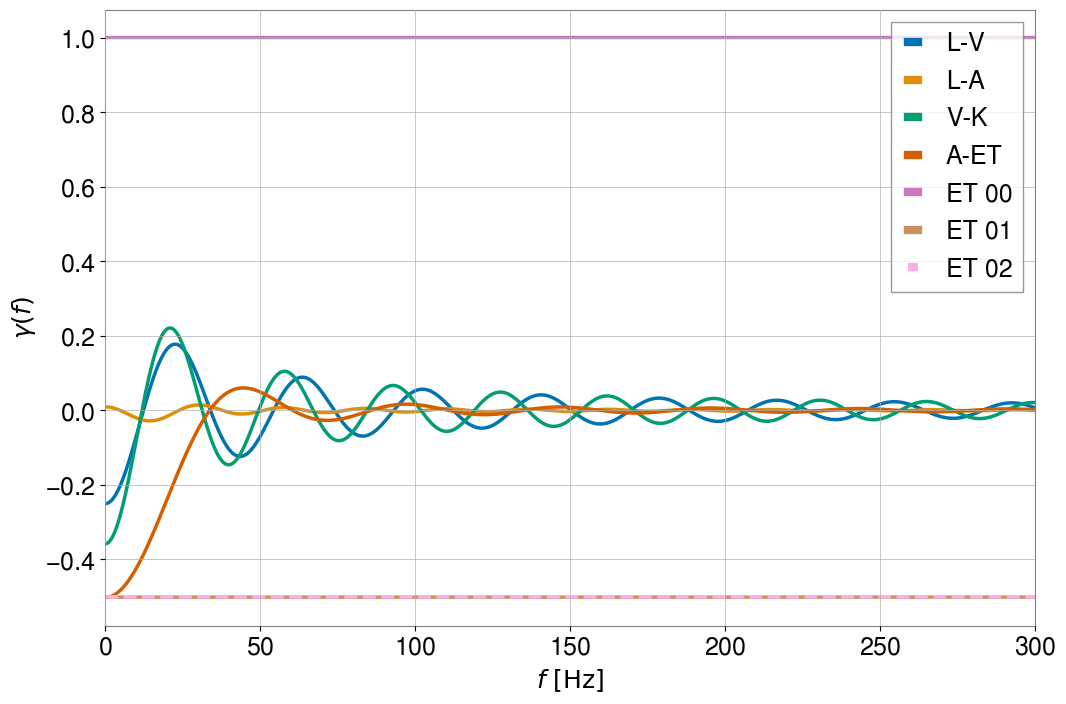

In [12]:
fig = plt.figure(figsize=(12,8))
for ii,baseline in enumerate([L1V1, L1A1, V1K1, A1ET, ET00, ET01, ET02]):
    baseline.orf_polarization = 'tensor'
    if baseline.name == 'ET 02':
        ls='--'
    else:
        ls='-'
    plt.plot(freqs, baseline.overlap_reduction_function, label=baseline.name, ls=ls, lw=2.5, c=my_palette[ii])
    
plt.legend(loc='upper right', prop={'size':18})
plt.xlim(0,300)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r'$f~[\mathrm{Hz}]$', fontsize = 18)
plt.ylabel(r'$\gamma(f)$', fontsize = 18)

This plot shows us that the ORFs are normalized to be 1 for coincident and coaligned detectors irrespective of the opening angle between their arms. For additional information on the computation of the ORF, we refer the user to the [documentation page](api/pygwb.orfs.html) of the module, as well as to the `Baseline` [module](api/pygwb.baseline.html) to see how the two modules interact with one another. 

## Check normalization for ET

What about for coincident detectors that are rotated with respect to each other? This is the case for the `ET01` and `ET02` baselines, which are basically equivalent to two coincident ET detectors rotated by 120 degrees. Let's verify this. First we make a copy of the `ET[0]` detector and rotate its x and y arm positions by 120 degrees. Then we create a baseline between the original `ET[0]` and this rotated copy.

In [10]:
ET_rot120 = deepcopy(ET[0])
ET_rot120.xarm_azimuth += 120
ET_rot120.yarm_azimuth += 120
ET_test120 = Baseline('ET rot', ET[0], ET_rot120, frequencies=freqs, duration=duration)
ET_test120.orf_polarization = 'tensor'

Now we plot for comparison with the `ET01` and `ET02` baselines above.

Text(0, 0.5, '$\\gamma(f)$')

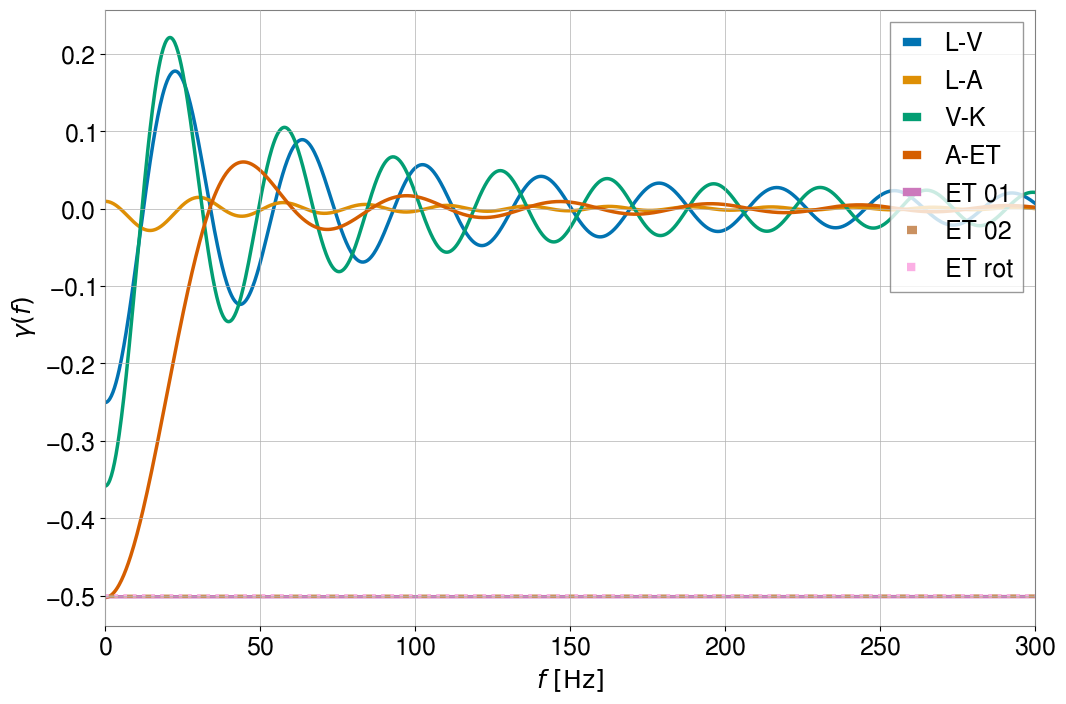

In [13]:
fig = plt.figure(figsize=(12,8))
for ii,baseline in enumerate([L1V1, L1A1, V1K1, A1ET, ET01, ET02, ET_test120]):
    if baseline.name == 'ET 02':
        ls='--'
    elif baseline.name == 'ET rot':
        ls=':'
    else:
        ls='-'
    plt.plot(freqs, baseline.overlap_reduction_function, label=baseline.name, ls=ls, lw=2.5, c=my_palette[ii])
    
plt.legend(loc='upper right', prop={'size':18})
plt.xlim(0,300)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r'$f~[\mathrm{Hz}]$',fontsize=18)
plt.ylabel(r'$\gamma(f)$',fontsize=18)

You can see that the three ET baselines lie nearly on top of each other, as expected. This tells us that the ORF normalization is such that $\gamma(f=0) = \cos{\beta}$, for arm opening angles of $\beta$.

## Plot non-GR polarizations
In addition, the `orfs` module also allows non-GR polarizations. This is illustrated below for scalar polarizations, but it can also be calculated for vector polarizations.

Text(0, 0.5, '$\\gamma(f)$')

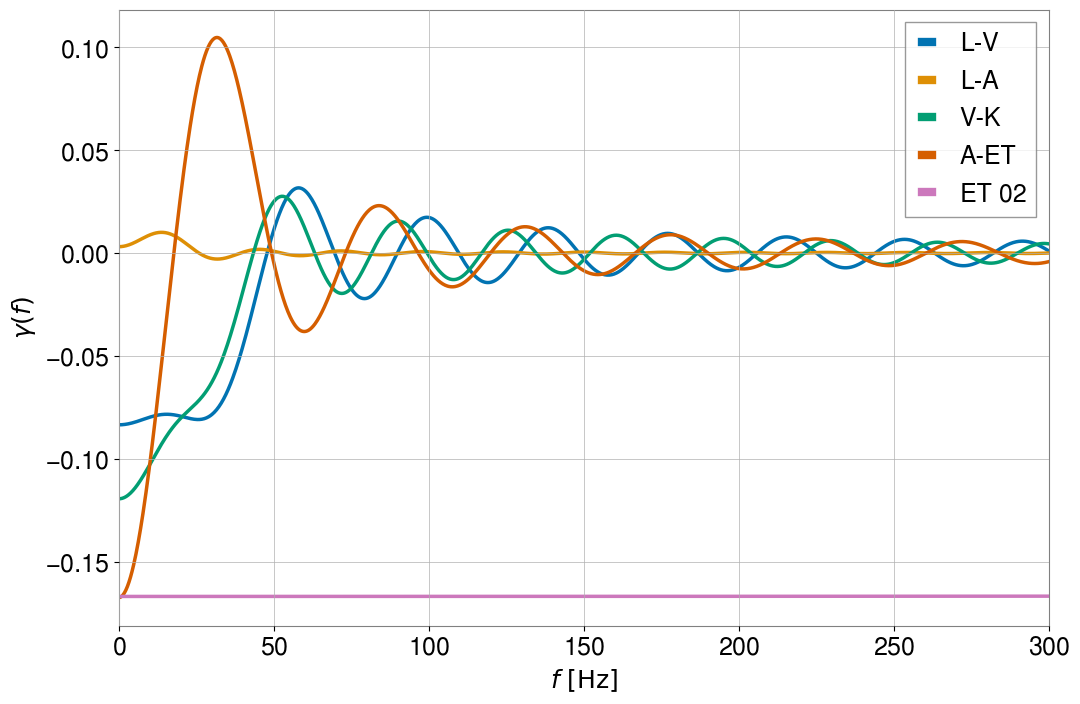

In [14]:
fig = plt.figure(figsize=(12,8))
for ii,baseline in enumerate([L1V1, L1A1, V1K1, A1ET, ET02]):
    baseline.orf_polarization = 'scalar'
    plt.plot(freqs, baseline.overlap_reduction_function, label=baseline.name, ls='-',lw=2.5, c=my_palette[ii])
    
plt.legend(loc='upper right', prop={'size':18})
plt.xlim(0,300)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r'$f~[\mathrm{Hz}]$',fontsize=18)
plt.ylabel(r'$\gamma(f)$',fontsize=18)

More information about how the ORFs are computed can be found in the [documentation](api/pygwb.orfs.html) of the `orfs` module.